# Horn of Africa

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import gc
import logging
import pandas as pd
from math import pi
import matplotlib.pyplot as plt

In [2]:
#relevant directories
MERRA2_T2M_U2M_QV2M_dir = '/g/data/rr7/MERRA2/raw/M2T1NXSLV.5.12.4'
MERRA2_SWGDN_dir = '/g/data/rr7/MERRA2/raw/M2T1NXRAD.5.12.4/'

#### Dask + warning setup

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38631,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33375,Total threads: 1
Dashboard: /proxy/39077/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:46263,


### Step 1 -> Extract hly T, q, Rd, U10 and convert to daily
Hourly MERRA2 files are very large - extract only relevant variables for domain of interest with dask and write locally (only need to do this step once)<br>
<sub>Need to write locally as working with dask arrays using .compute crashes the session and takes a long time</sub>

In [5]:
# %%time
# def preprocess_U2M_V2M(ds):
#     logging.getLogger('flox').setLevel(logging.WARNING)
#     return ds[['V2M', 'U2M']].sel(lat=slice(-5,15), lon=slice(33,52))

# for year in range(1980,2023):
#     T2M_U2M_QV2M_files = []
#     for month in range(1,13):
#         T2M_U2M_QV2M_files.extend(sorted(glob.glob(f"{MERRA2_T2M_U2M_QV2M_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

#     U2M_V2M_cube = xr.open_mfdataset(T2M_U2M_QV2M_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_U2M_V2M, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
    
#     #write to netcdf and clear up local memory, ok to store locally only takes ~1.5gb
#     U2M_V2M_cube.to_netcdf(f'/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/hly/{year}_MERRA2_U2M_V2M.nc', encoding={'U2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'V2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
#     del U2M_V2M_cube
#     gc.collect()

In [6]:
# %%time
# wind = xr.open_mfdataset(['/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/hly/'+file for file in os.listdir('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/hly')],combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})
# W2M = (((wind['U2M']**2)+(wind['V2M']**2))**0.5).rename('W2M')
# W2M.to_netcdf('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/MERRA2_hly_W2M.nc', encoding={'W2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})

# W2M = xr.open_dataset('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/MERRA2_hly_W2M.nc')['W2M'].sortby("time").resample(time='1D').mean()
# W2M.to_netcdf('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/MERRA2_daily_W2M.nc', encoding={'W2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})

In [7]:
# %%time
# #load in incoming surface solar radiation (W/m2) and aggregate to daily timescale
# SWGDN_files = []
# for year in range(1980,2023):
#     for month in range(1,13):
#         SWGDN_files.extend(sorted(glob.glob(f"{MERRA2_SWGDN_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

# def preprocess_SWdn(ds): #preprocess function to save memory and time
#     logging.getLogger('flox').setLevel(logging.WARNING)
#     # return ds['SWGDN'].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))
#     return ds['SWGDN'].resample(time='1D').sum().sel(lat=slice(-5,15), lon=slice(33,52))

# SWGDN_cube = xr.open_mfdataset(SWGDN_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_SWdn, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

# #write to netcdf and clear up local memory, ok to store locally only takes ~500mb
# SWGDN_cube.to_netcdf('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/MERRA2_daily_SWGDN_sum.nc', encoding={'SWGDN': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
# del SWGDN_cube
# gc.collect()

<br> 

### Step 2 -> Calculate daily reference ET and convert to 7-day running means

<br>Inputs

In [2]:
T2M_U2M_QV2M_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA/MERRA2_daily_T2M_U2M_QV2M.nc')
W2M_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA/MERRA2_daily_W2M.nc')
PS_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA/MERRA2_daily_PS.nc')
SWGDN_cube = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA/MERRA2_daily_SWGDN.nc') 

Patm = PS_cube['PS'] #Surface pressure [Pa]
T2M = T2M_U2M_QV2M_cube['T2M'] #2-m daily mean air temperature [K]
U2M = np.abs(T2M_U2M_QV2M_cube['U2M']) #2-m eastward wind speed [m/s]
W2M = W2M_cube['W2M'].interp_like(U2M) #2-m wind speed [m/s]
QV2M = T2M_U2M_QV2M_cube['QV2M'] #2-m specific humidity [kg/kg]
SWGDN = SWGDN_cube['SWGDN'] #surface downwave shortwave radiation flux [W/m2]


In [3]:
SWGDN.sel(lat='3', lon='41.25', time='1990-01-01').item()

290.2368469238281

In [4]:
QV2M.sel(lat='3', lon='41.25', time='1990-01-01').item()

0.007978050969541073

In [5]:
Patm.sel(lat='3', lon='41.25', time='1990-01-01').item()

96372.5625

In [6]:
W2M.sel(lat='3', lon='41.25', time='1990-01-01').item()

2.9905011653900146

<br>Elevation - following approach from Mike's [MERRA2 paper code](https://www.sciencebase.gov/catalog/item/6515cb7ad34e469cabfcdccd), elev file not stored on gadi so downloaded locally from NASA earthdata

In [7]:
elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/MERRA2_101.const_2d_asm_Nx.nc4')

geopot = elevfile['PHIS'].sel(lat=slice(-5,15), lon=slice(33,52))#.sel(lat=slice(-45,-1), lon=slice(100,180))[0]
elev = geopot[0]/9.81 #divide by 9.81m2/s to get elevation [m]

In [8]:
elev.sel(lat='3', lon='41.25').item()

404.4305114746094

<br>Switch for short crop (0.12m grass) or tall crop (0.50m alfafa)

In [9]:
short_tall_crop_switch = 'tall' #short (0.12m grass) or tall (0.50m alfafa)

### Ref ET using [FAO56](https://github.com/jb6465/flash-drought/blob/main/relevant_studies/FAO56.pdf) / Mike fortran code units

<br>Constants

In [10]:
# Cn: numerator crop constant [K.m.s3/(kg.day)]
Cn = 1.6 if short_tall_crop_switch == 'tall' else 0.9 

In [11]:
# Cd: denominator crop constant [s/m]
Cd = 0.38 if short_tall_crop_switch == 'tall' else 0.34

In [12]:
# Gsc: solar constant [J/(m2.hr)]
Gsc = 4.92e6

In [13]:
# sigma: Stefan-Boltzmann constant [J/(K4.m2.day)]
sigma = 4.901e-3

In [14]:
# albedo [unitless]
albedo = 0.23

<br>Input variables

In [15]:
# Rs: downwelling short wave radiation [J/(m2.day)]
Rs = (SWGDN * 86400)

In [16]:
# T: daily mean temperature [°C]
T = T2M-273.15

In [17]:
# Patm: surface pressure [Pa] = f(elev[m])                                                [FAO56 Eq. 7]
# Patm = 101300 * ((293. - 0.0065 * elev) / 293.)**5.26

In [18]:
# gamma: psychrometric constant [Pa/°C]                                                   [FAO56 Eq. 8]
gamma = 0.665e-3 * Patm

In [19]:
# esat: saturated vapor pressure [Pa] = f(T[°C])            ,                             [FAO56 Eq. 11]
esat = 610.8 * np.exp((17.27*T/(T+237.3)))

In [20]:
# w: mixing ratio [kg/kg] = f(QV2M[kg/kg])                                                
w = QV2M / (1. - QV2M)

In [21]:
# eact: actual vapor pressure [Pa] = f(Patm[Pa], w[kg/kg])                                [FAO56 Eq. ???]
eact = (Patm * w) / (0.622 + w)
eact = eact.clip(max=esat) #clip eact ≤ esat

In [22]:
# delta: slope of the saturated vapor pressure curve at T [Pa/K] = f(T[°C])               [FAO56 Eq. 13]
delta = (4098. * 610.8 * np.exp(17.27 * T / (T + 237.3))) / (T + 237.3)**2 

In [23]:
# G: ground heat flux  [MJ/(m2.day)], on daily time scales, G ≈ 0                         [FAO56 Eq. 42]
G = 0 

In [24]:
# decl: declination [radians] = f(pi[unitless], jday[unitless])                           [FAO56 Eq. 42]
jday = xr.DataArray(SWGDN.time.dt.dayofyear.values, coords=[('day', SWGDN.time.dt.dayofyear.values)], dims=["day"])
decl = 0.409 * np.sin((2. * np.pi * jday / 365) - 1.39)

In [25]:
# ws: sunset hour angle ws[radians] = f(latitude[rad], dec[rad])                          [FAO56 Eq. 25]
Lat = SWGDN.lat
ws = np.arccos(-1 * np.tan(np.deg2rad(Lat)) * np.tan(decl))

In [26]:
# dr: inverse relative distance of earth from sun [unitless]                              [FAO56 Eq. 23]
dr = 1. + 0.033 * np.cos(2. * np.pi * jday / 365)

In [27]:
# Ra: extra-terrestrial (TOA) SW radiation [J/(m2.day)] = 
#f(Gsc [J/m2/hour], dr [unitless], ws [rad], Lat [rad], decl [rad])                       [FAO56 Eq. 21] 
Ra = (24. / np.pi) * Gsc * dr * (ws * np.sin(np.deg2rad(Lat)) * np.sin(decl) + np.cos(np.deg2rad(Lat)) * np.cos(decl) * np.sin(ws))

In [28]:
# Rso: clear-sky SW radiation at surface [J/m2/day] = f(Ra[J/(m2.day)], elev[m])          [FAO56 Eq. 37]
Rso = Ra * (0.75 + 2e-5 * elev)

In [29]:
# fcd: cloudiness function [unitless]                                                     [FAO56 pg. 79]
RsRso = xr.DataArray((Rs.values)/(Rso.values), coords=[('time', Rs.time.values), ('lat', Rs.lat.values), ('lon', SWGDN.lon.values)], dims=["time", "lat", "lon"])
RsRso = RsRso.clip(min=0.3, max=1.0)
fcd = 1.35 * RsRso - 0.35 
fcd = fcd.clip(min=0.05, max=1.0) #clip values between 0.05 and 1.0

In [30]:
# Rns: Net shortwave radiation  [J/(m2.day)]                                             [FAO56 Eq. 38]
Rns = (1 - albedo) * Rs

In [31]:
# Rnl: net LW radiation upward[J/(m2.day)] = f(sigma [J/(K4.m2.day)], eact[Pa], T[°C])   [FAO56 Eq. 39]
Rnl = sigma * fcd * (0.34 - 0.14 * (0.001 * eact)**0.5) * (T + 273.15)**4.

In [32]:
# Rn: net radiation [J/(m2.day)]
Rn = Rns - Rnl

<br><b>Split ET0 into 3 components: A, B, C</b><br>
From FAO56, Equation 6, PM derivation of ET0
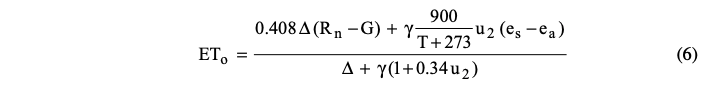

In [33]:
%%time
# A left numerator
A = (0.408*1e-6) * (delta) * (Rn - G)

# B right numerator
B = (gamma) * (Cn/(T+273)) * W2M * ((esat-eact)) #(gamma) * (Cn/(T+273)) * U2M * ((esat-eact))

# C denominator
C = ((delta) + (gamma) * (1+Cd*W2M)) #((delta) + (gamma) * (1+Cd*U2M))

ET0 = (A+B)/C

CPU times: user 423 ms, sys: 459 ms, total: 881 ms
Wall time: 879 ms


In [34]:
ET0_xr = xr.DataArray(ET0, dims=['time', 'lat', 'lon'], coords={'time':T.time.values, 'lat': T.lat.values, 'lon': T.lon.values}).rename(f"ET0_{short_tall_crop_switch}_crop")

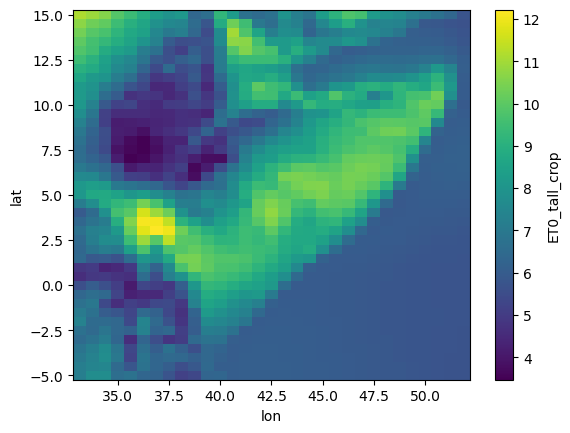

In [35]:
ET0_xr.mean(dim='time').plot()

In [36]:
ET0_xr.sel(lat='3', lon='41.25', time='1990-01-01').item()

10.338098169486988

In [37]:
# ET0_xr.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/ET0.csv')
# SWGDN.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/SWdn.csv')
# Patm.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Patm.csv')
# QV2M.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/SpHm.csv')
# W2M.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/W2M.csv')
# T2M.sel(lat='3', lon='41.25').to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/T2M.csv')

In [38]:
# from functools import reduce
# df = reduce(lambda l, r: pd.merge(l, r, on='time'), [pd.read_csv(f"/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/{f}").drop(['lat', 'lon'], axis=1) for f in ["ET0.csv", "SWdn.csv", "Patm.csv", "SpHm.csv", "W2M.csv", "T2M.csv"]])

In [39]:
# df.to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/combined.csv')

In [46]:
# jess = pd.read_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/jess.csv')
# mike = pd.read_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/mike.csv')

In [47]:
# (mike-jess).to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/mike-jess.csv')

<br>

### Step 3 -> Calculate daily sensitivity expressions

to calculate sensitvities need driver 7-day smoothed doy means for an appropriate reference period

In [40]:
short_tall_crop_switch='tall'

In [41]:
#function to mask ocean 
def mask_ocean(input_daily_xr):
    import regionmask
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(input_daily_xr)
    masked_daily_xr = input_daily_xr.where(land_mask==0, np.nan)
    return masked_daily_xr

def compute_rolling_xday(daily, n_rolling_days, centre_window=True):
    x_day = daily.rolling(time=n_rolling_days, center=centre_window).mean()
    return x_day
    
def compute_doy_climo(input_xr): 
    climo = input_xr.assign_coords(doy=input_xr['time'].dt.dayofyear).groupby('doy').mean('time')
    return climo
    
def compute_daily_anom(input_xr): 
    climo = compute_doy_climo(input_xr)
    x_day_anom = input_xr.groupby('time.dayofyear') - climo.rename({'doy': 'dayofyear'})
    return x_day_anom


In [42]:
T = compute_doy_climo(compute_rolling_xday(T2M-273.15, 7, True))
Rs = compute_doy_climo(compute_rolling_xday(SWGDN*86400, 7, True))
q = compute_doy_climo(compute_rolling_xday(QV2M, 7, True))
U = compute_doy_climo(compute_rolling_xday(W2M, 7, True))
Patm = compute_doy_climo(compute_rolling_xday(Patm, 7, True))

In [43]:
#constants
albedo = 0.23
sigma = 4.901e-3 
Cn = 1.6 if short_tall_crop_switch == 'tall' else 0.9
Cd = 0.38 if short_tall_crop_switch == 'tall' else 0.34
Gsc = 4.92e6

#equations ~ same as for compute ET0 function but need to be replicated here for the computation with doy means required for sensitivity
sigma = 4.901e-3
gamma = 0.665e-3 * Patm
esat = 610.8 * np.exp((17.27*T/(T+237.3))) 

w = q / (1. - q)
eact = (Patm * w) / (0.622 + w)
eact = eact.clip(max=esat)

delta = (4098. * 610.8 * np.exp(17.27 * T / (T + 237.3))) / (T + 237.3)**2
G = 0       
Rns = (1 - albedo) * Rs
jday = xr.DataArray(Rs.doy.values, coords=[('doy', Rs.doy.values)], dims=["doy"])
decl = 0.409 * np.sin((2. * np.pi * jday / 365) - 1.39)                                                                   
ws = np.arccos(-1 * np.tan(np.deg2rad(Rs.lat)) * np.tan(decl))
dr = 1. + 0.033 * np.cos(2. * np.pi * jday / 365)                           
Ra = (24. / np.pi) * Gsc * dr * (ws * np.sin(np.deg2rad(Rs.lat)) * np.sin(decl) + np.cos(np.deg2rad(Rs.lat)) * np.cos(decl) * np.sin(ws))
Rso = Ra * (0.75 + 2e-5 * elev)
RsRso = xr.DataArray((Rs.values)/(Rso.values), coords=[('doy', Rs.doy.values), ('lat', Rs.lat.values), ('lon', Rs.lon.values)], dims=["doy", "lat", "lon"])
RsRso = RsRso.clip(min=0.3, max=1.0)
fcd = 1.35 * RsRso - 0.35 
fcd = fcd.clip(min=0.05, max=1.0) #clip values between 0.05 and 1.0

Rns = (1 - albedo) * Rs
Rnl = sigma * fcd * (0.34 - 0.14 * (0.001 * eact)**0.5) * (T + 273.15)**4.
Rn = Rns - Rnl

In [44]:
A = (0.408*1e-6) * (delta) * (Rn - G)   
ATa = 0.408e-6 * (2.503e6 * np.exp(17.27 * T / (T + 237.3))/ (T + 237.3)**2.) 
ATb = (Rns - (sigma * fcd * (0.34 - 0.14 * (0.001 * (eact))**0.5)* (T + 273.15)**4.))
dATadT = -(2.04245 * np.exp((17.27 * T) / (T + 237.3))* (T**2. * (T + 237.3)**2. - 2049.09 *(T + 237.3)**3 + 474.6 * T * (T + 237.3)**2. + 56311.3 * (T + 237.3)**2.))/ (T + 237.3)**7.
dATbdT = 0.0177088 * fcd * (-76.7982 + (eact)**0.5) * sigma * (T + 273.15)**3.
dAdT = ATa * dATbdT + ATb * dATadT
dAdq = (2.41719e-9 * delta * fcd * Patm * (q - 1.)* sigma * (273.15 + T)**4.)/ ((q - 1.) * ((Patm * q)/ (1.6455 + q))**0.5 * (1.6455 + q)**2.)
dAdR = -0.0352512 * (albedo - 1.) * (delta) + (0.000210686 * (delta) * (-76.7982 + (eact)**0.5) * sigma * (273.15 + T)**4) / Rso.values

In [45]:
B = (gamma) * (Cn/(T+273)) * U * ((esat-eact)) 
B = B.transpose('doy', 'lat', 'lon')
dBdT = -1.*(67.3431 * Cn * (610.8 * np.exp((17.27 * T) / (237.3 + T)) - (Patm * q) / ((1 - q) * (0.622 + q / (1 - q)))) * U) / (273.15 + T)**2. + (41133.2 * Cn * np.exp((17.27 * T) / (237.3 + T)) * (-(17.27 * T) / (237.3 + T)**2. + 17.27 / (237.3 + T)) * U) / (273.15 + T)
dBdq = (Cn * Patm * 293.157 * (1 - q) * U)/ ((q - 1.) * (1.6455 + q)**2. * (273.15 + T))
dBdU = (0.000665 * Cn * Patm * (610.8 * np.exp((17.27 * T)/(237.3 + T)) - (Patm * w)/(0.622 + w)))/(273.15 + T)

In [46]:
C = ((delta) + (gamma) * (1+Cd*U)) 
dCdT = -(5006000. * np.exp((17.27 * T)/(237.3 + T)) * (-1811.79 + T))/ (237.3 + T)**4.
dCdU = 0.000665 * Cd * Patm

In [47]:
sens_T = (dAdT + dBdT - (A + B) * dCdT / C) / C

In [48]:
sens_R  = dAdR / C

In [49]:
sens_q  = (dAdq + dBdq) / C

In [50]:
sens_U  = ((C * dBdU) - (A + B) * dCdU) / C**2

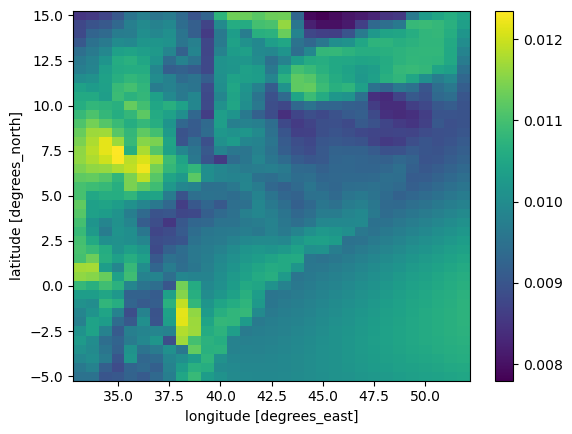

In [51]:
sens_R.mean(dim='doy').plot()

In [141]:
# sens_T.sel(lat='3', lon='41.25').rename("sens_T").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/sens_T.csv')
# sens_R.sel(lat='3', lon='41.25').rename("sens_R").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/sens_R.csv')
# sens_q.sel(lat='3', lon='41.25').rename("sens_q").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/sens_q.csv')
# sens_U.sel(lat='3', lon='41.25').rename("sens_U").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/sens_U.csv')

<br>

### Step 4 -> Case Study / Testing

In [142]:
# ET0.sel(lat='3', lon='41.25').rename("ET0").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/ET0.csv')

# ET0_7d.sel(lat='3', lon='41.25').rename("ET0_7d").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/ET0_7d.csv')
# ET0_climo.sel(lat='3', lon='41.25').rename("ET0_climo").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/ET0_climo.csv')
# ET0_anom.sel(lat='3', lon='41.25').rename("ET0_anom").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/ET0_anom.csv')

# T.sel(lat='3', lon='41.25').rename("T").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/T.csv')
# T_7d.sel(lat='3', lon='41.25').rename("T_7d").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/T_7d.csv')
# T_climo.sel(lat='3', lon='41.25').rename("T_climo").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/T_climo.csv')
# T_anom.sel(lat='3', lon='41.25').rename("T_anom").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/T_anom.csv')

# Rs.sel(lat='3', lon='41.25').rename("Rs").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Rs.csv')
# Rs_7d.sel(lat='3', lon='41.25').rename("Rs_7d").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Rs_7d.csv')
# Rs_climo.sel(lat='3', lon='41.25').rename("Rs_climo").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Rs_climo.csv')
# Rs_anom.sel(lat='3', lon='41.25').rename("Rs_anom").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Rs_anom.csv')

# QV2M.sel(lat='3', lon='41.25').rename("QV2M").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/QV2M.csv')
# Q_7d.sel(lat='3', lon='41.25').rename("Q_7d").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Q_7d.csv')
# Q_climo.sel(lat='3', lon='41.25').rename("Q_climo").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Q_climo.csv')
# Q_anom.sel(lat='3', lon='41.25').rename("Q_anom").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/Q_anom.csv')

# W2M.sel(lat='3', lon='41.25').rename("W2M").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/W2M.csv')
# W2M_7d.sel(lat='3', lon='41.25').rename("W2M_7d").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/W2M_7d.csv')
# W2M_climo.sel(lat='3', lon='41.25').rename("W2M_climo").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/W2M_climo.csv')
# W2M_anom.sel(lat='3', lon='41.25').rename("W2M_anom").to_dataframe().to_csv('/g/data/mn51/users/jb6465/data/MERRA2_data/HOA/csvs/W2M_anom.csv')


In [143]:
start_idx = 13301
end_idx = 13666 

In [144]:
ET0_anom = compute_daily_anom(compute_rolling_xday(ET0_xr, 7, True))

T_anom = compute_daily_anom(compute_rolling_xday(T2M, 7, True))
Rs_anom = compute_daily_anom(compute_rolling_xday(SWGDN, 7, True))
Q_anom = compute_daily_anom(compute_rolling_xday(QV2M, 7, True))
W2M_anom = compute_daily_anom(compute_rolling_xday(W2M, 7, True))

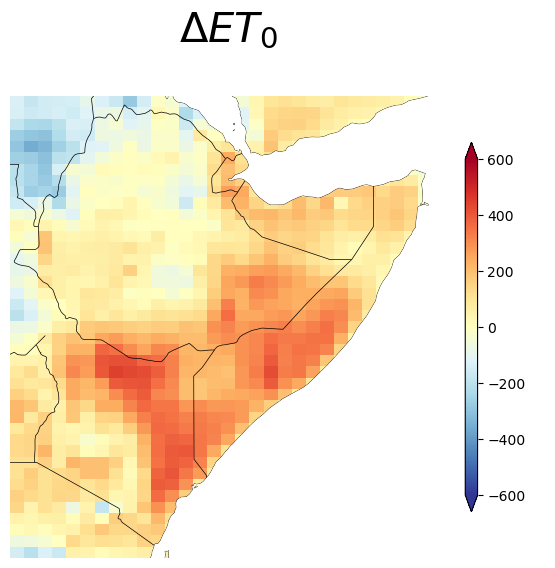

<Figure size 640x480 with 0 Axes>

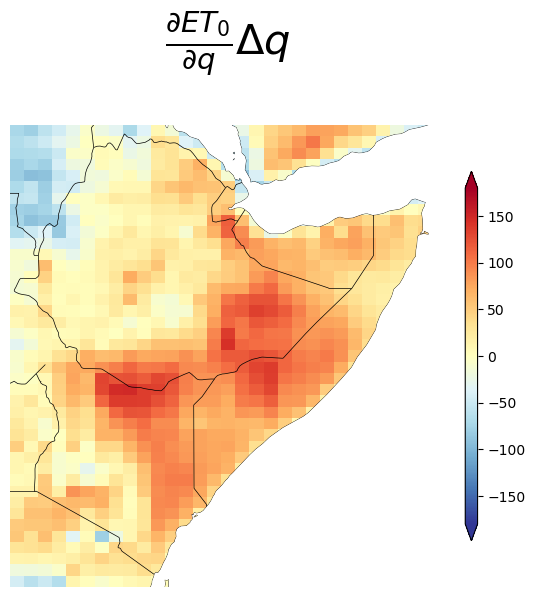

<Figure size 640x480 with 0 Axes>

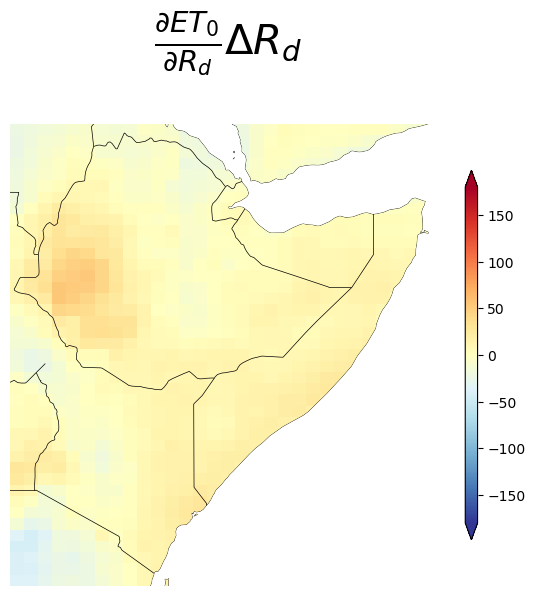

<Figure size 640x480 with 0 Axes>

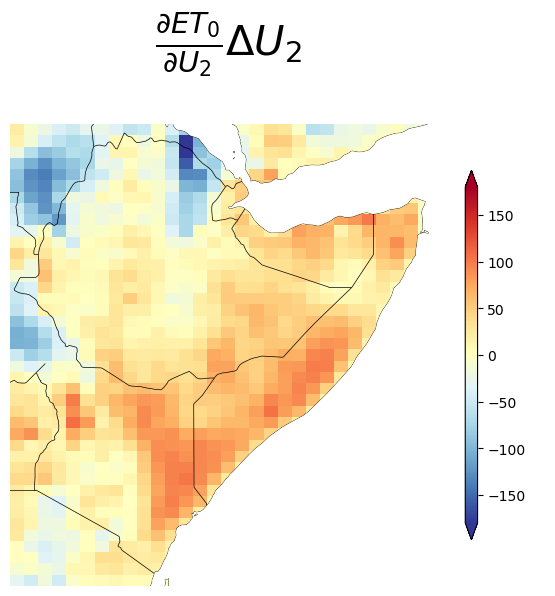

<Figure size 640x480 with 0 Axes>

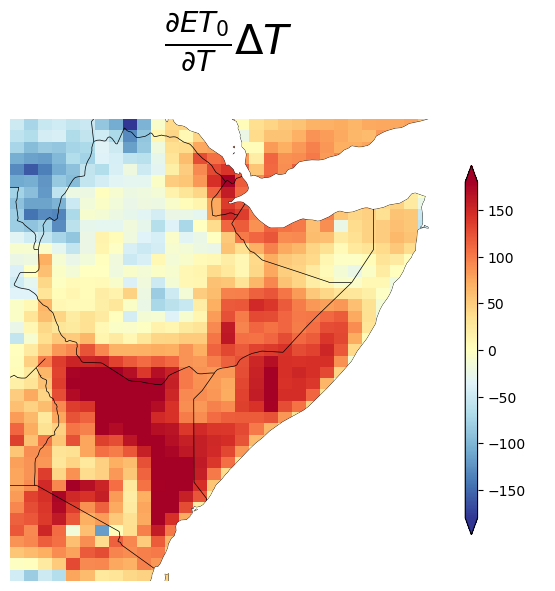

<Figure size 640x480 with 0 Axes>

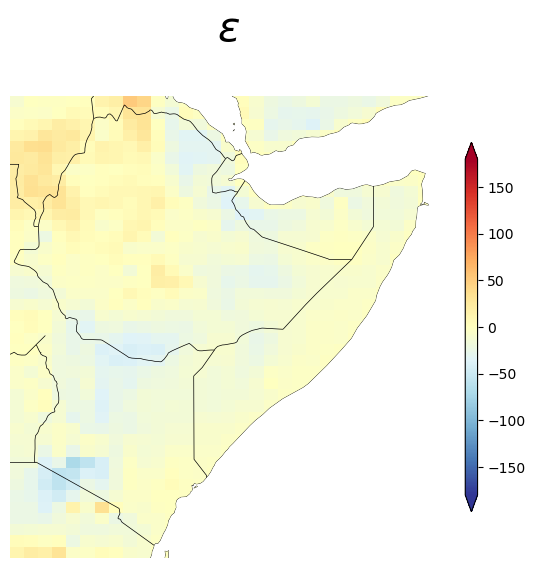

CPU times: user 1.08 s, sys: 301 ms, total: 1.38 s
Wall time: 1.37 s


<Figure size 640x480 with 0 Axes>

In [145]:
%%time
import cartopy.crs as ccrs
import cartopy.feature as cfeature

et0_plot = ET0_anom[start_idx:end_idx].sum(dim='time', skipna=False)

q_plot = ((Q_anom*sens_q.sel(doy=Q_anom['time'].dt.dayofyear))[start_idx:end_idx]).sum(dim='time', skipna=False)
R_plot = ((Rs_anom*sens_R.sel(doy=Rs_anom['time'].dt.dayofyear))[start_idx:end_idx]).sum(dim='time', skipna=False)
U_plot = ((W2M_anom*sens_U.sel(doy=W2M_anom['time'].dt.dayofyear))[start_idx:end_idx]).sum(dim='time', skipna=False)
T_plot = ((T_anom*sens_T.sel(doy=T_anom['time'].dt.dayofyear))[start_idx:end_idx]).sum(dim='time', skipna=False)
closure_plot = et0_plot - T_plot - q_plot - R_plot - U_plot

labels = [r"$\Delta ET_0$"+"\n",\
         r"$\frac{\partial ET_0}{\partial q} \Delta q$"+"\n",\
         r"$\frac{\partial ET_0}{\partial R_d} \Delta R_d$"+"\n",\
         r"$\frac{\partial ET_0}{\partial U_2} \Delta U_2$"+"\n",\
         r"$\frac{\partial ET_0}{\partial T} \Delta T$"+"\n",\
         r"$\epsilon$"+"\n"]

for idx, input_array in enumerate([et0_plot, q_plot, R_plot, U_plot, T_plot, closure_plot]):
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    lon, lat = np.meshgrid(input_array['lon'], input_array['lat'])
    mesh = ax.pcolormesh(lon, lat, input_array, transform=ccrs.PlateCarree(), vmin=-600 if idx==0 else -180, vmax=600 if idx==0 else 180, cmap='RdYlBu_r', shading='auto') #ax.pcolormesh(lon, lat, input_array, transform=ccrs.PlateCarree(), vmin=-150 if idx==0 else -75, vmax=150 if idx==0 else 75, cmap='RdYlBu_r', shading='auto')
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', label=' ', shrink=0.8, extend='both', aspect=30, pad=0.02)
    
    # ax.set_title(fr"{labels[idx]} $_{{\mathrm{{July\ 2015\ to\ December\ 2015}}}}$", size=30, pad=20)
    ax.set_title(fr"{labels[idx]}", size=30)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
    ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
    ax.add_feature(cfeature.OCEAN, zorder=10, facecolor='white', alpha=1)
    ax.set_frame_on(False)
    plt.show()
    plt.clf()

#### quick check of this nb with new functions

In [85]:
sys.path.append('/g/data/mn51/users/jb6465/code/flash-drought/attribution-python')
from decomposition import *
from plotting import *
from extract import *

In [162]:
%%time
for year in range(2016, 2018): 
    #Mask ocean amd ingest ET0 inputs
    Rs = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/SWGDN/HOA_MERRA2_{year}_SWGDN_day.nc').SWGDN)
    T = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_T2MDEW_QV2M_PS/HOA_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').T2M)
    Tdew = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_T2MDEW_QV2M_PS/HOA_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').T2MDEW)
    Tmax = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_MAX/HOA_MERRA2_{year}_T2M_MAX_day.nc').T2M)
    Tmin = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_MIN/HOA_MERRA2_{year}_T2M_MIN_day.nc').T2M)
    Patm = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_T2MDEW_QV2M_PS/HOA_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').PS)
    W2M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/W2M/HOA_MERRA2_{year}_W2M_day.nc').W2M)
    Q2M = mask_ocean(xr.open_dataset(f'/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/T2M_T2MDEW_QV2M_PS/HOA_MERRA2_{year}_T2M_T2MDEW_QV2M_PS_day.nc').QV2M)
    
    elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/MERRA2_101.const_2d_asm_Nx.nc4')
    geopot = elevfile['PHIS'].sel(lat=slice(domain_dict['HOA']['lat_min'], domain_dict['HOA']['lat_max']), lon=slice(domain_dict['HOA']['lon_min'], domain_dict['HOA']['lon_max']))
    elev = geopot[0]/9.81 #divide by 9.81m2/s to get elevation [m]
    
    #compute ET0 and components
    sens_T_, sens_R_, sens_q_, sens_U_, ET0 = compute_and_decompose_ET0(Rs*86400, T-273.15, Tmax-273.15, Tmin-273.15, Tdew-273.15, Patm, W2M, Q2M, None, None, None, elev,
                                                                    short_tall_crop_switch='tall', T2M_model_or_derived='model', Patm_model_or_derived='model', esat_method='Tmean', eact_method='Patm_q', Rnl_method='Tmean')
    
    if not os.path.isfile(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/ET0/ET0_tall_MERRA2_{year}.nc"):
        os.makedirs("/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/ET0/", exist_ok=True)
        xr.Dataset({"T_sens": sens_T, "R_sens": sens_R, "q_sens": sens_q, "U_sens": sens_U, "ET0_tall_crop": ET0}).reset_coords(drop=True).to_netcdf(f"/g/data/mn51/users/jb6465/data/flash_drought/reanalysis/MERRA2/archived/HOA_new_function_check/ET0/ET0_tall_MERRA2_{year}.nc", encoding={v: {"zlib": True, "complevel": 5, "dtype": "float32"} for v in ["T_sens","T_sens","T_sens","U_sens","ET0_tall_crop"]})
    break

CPU times: user 5.01 s, sys: 31.7 ms, total: 5.04 s
Wall time: 5.08 s


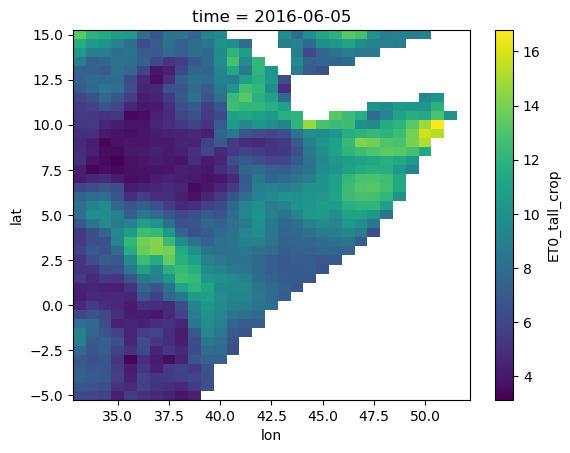

In [269]:
mask_ocean(ET0_xr[13305]).plot() ## old from earlier in the notebook

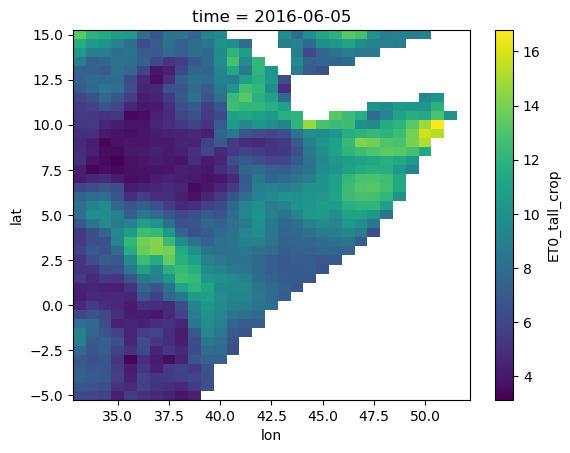

In [270]:
ET0.sel(time='2016-06-05').plot() #new function (identical)

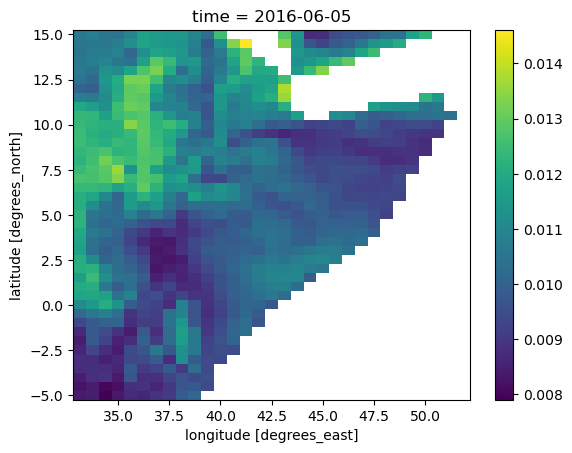

In [277]:
mask_ocean(sens_R[13305]).plot() ## old from earlier in the notebook

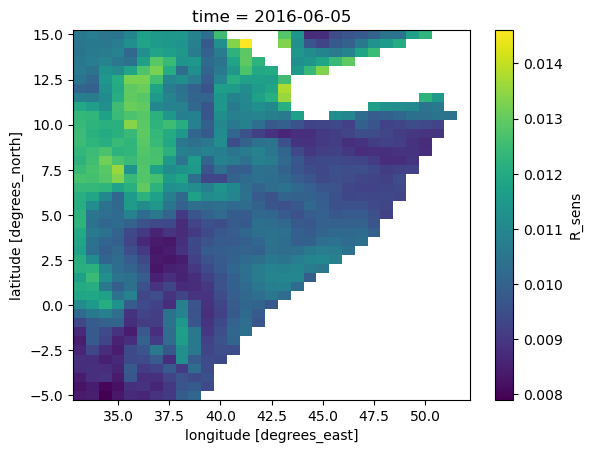

In [278]:
sens_R_.sel(time='2016-06-05').plot() #new function (identical)